In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import constants
import os
from dotenv import load_dotenv

## Data Visualization and Preprocessing

### Read data

In [2]:
load_dotenv()
dataset_path = os.getenv('DATASET_PATH')

def get_genuine_csv_mat_files(data_category = constants.GENUINE, data_type = constants.TRAIN):
    user_ids = []
    files_csv = []
    files_mat = []

    # Get training and testing data
    data_split = pd.read_csv(os.path.join(dataset_path, "Identification_split.csv"))
    training_data_files = data_split[data_split.set == constants.TRAIN].filename.str.rsplit('.', n=1).str[0]
    # print(training_data_files) # only for debugging

    for root, dirs, files in os.walk(dataset_path):
        if os.path.basename(root) == constants.GENUINE == data_category:
            for file in files:
                if file.endswith('.csv'):
                    files_csv.append(os.path.join(root, file))
                elif file.endswith('.mat'):
                    files_mat.append(os.path.join(root, file))
        elif os.path.basename(root) == constants.FORGED == data_category:
            for file in files:
                if file.endswith('.csv'):
                    files_csv.append(os.path.join(root, file))
                elif file.endswith('.mat'):
                    files_mat.append(os.path.join(root, file))
        if os.path.basename(root) != constants.GENUINE and os.path.basename(root) != constants.FORGED and os.path.basename(root) != 'SignEEGv1.0':
            user_ids.append(os.path.basename(root))
    return files_csv, files_mat, user_ids

# print("Genuine MAT files:")
# pprint(get_genuine_csv_mat_files())
# print("Forged MAT files:")
# pprint(get_forged_csv_mat_files())

### Get List of UserIDs from Dataset

In [4]:
# user_ids = []
# def get_list_of_user_ids():
#     for root, dir, files in os.walk(dataset_path):
#         if os.path.basename(root) != 'Genuine' and os.path.basename(root) != 'Forged' and os.path.basename(root) != 'SignEEGv1.0':
#             user_ids.append(os.path.basename(root))
#     # print(len(user_ids))
#     return user_ids

# print("User IDs:")
# pprint(get_list_of_user_ids())
    

### Clean up Signature CSV data and reset column names

In [3]:
def get_user_csv_sign_data_cleaned(user_sign_data_csv): #Provide file name of the csv file
    content = pd.read_csv(user_sign_data_csv, skiprows=1, header=None)
    content.drop
    content.columns = [c.strip() for c in content.iloc[0]] #gettting rid of extra space in column names
    content = content.iloc[1:]
    return content


### Plot signature

In [6]:
import matplotlib.cm as cm

In [7]:
csv_data, _ = get_genuine_csv_mat_files()
print(csv_data)
user_id = '000000001045402'
user_match = [data for data in csv_data if user_id in data]
print("Users matched with user_id '{}':".format(user_match))
count=0
for file in user_match:
    count+=1
    content = get_user_csv_sign_data_cleaned(file)
    x, y, _, press, _, _ = normalize_sign_data(content)
    # cmap = cm.Blues
    # colors = cmap(press)
    # # colors[:, 3] = press
    # # plt.scatter(sign_coords['X'], sign_coords['Y'], c=colors, s=50)
    # plt.scatter(x, y, c=colors, s=50)
    # plt.title('Sign Coordinates')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.show()

    min_linewidth = 0
    max_linewidth = 5.0
    linewidths = min_linewidth + press * (max_linewidth - min_linewidth)

    plt.figure(figsize=(8, 4))
    for i in range(len(x) - 1):
        plt.plot(
            x[i:i+2], y[i:i+2],
            linewidth=linewidths[i],
            color='black',
            solid_capstyle='round'
        )
    # plt.axis('equal')  # Keep aspect ratio square
    plt.axis('off')    # Hide axes for cleaner look
    # plt.show() # uncomment only for debug processes, uncommenting will make plt.savefigure() save blank images

    plt.savefig("SignImages\\"+user_id+"-"+str(count)+".jpeg", dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

FileNotFoundError: [Errno 2] No such file or directory: 'Identification_split.csv'

### Signature Data Preprocessing

In [4]:
def normalize_sign_data(data):
    x = np.array(data['X']).astype(int)
    y = np.array(data['Y']).astype(int)
    t = np.array(data['T']).astype(int)
    pressure = np.array(data['Pressure']).astype(int)
    azimuth = np.array(data['Azimuth']).astype(int)
    altitude = np.array(data['Altitude']).astype(int)
    # normalize signature data
    norm_x = x / np.max(x)
    norm_y = y / np.max(y)
    norm_pressure = pressure / np.max(pressure)
    norm_azimuth = azimuth / np.max(azimuth)
    norm_altitude = altitude / np.max(altitude)
    return norm_x, norm_y, t, norm_pressure, norm_azimuth, norm_altitude

## Feature Extraction

### Signature data features

In [ ]:
# sign_data = get_user_csv_sign_data_cleaned('D:\\KCL Final Year Individual Project\\Implementation\\Project Implementation\\Dataset\\SignEEGv1.0\\SignEEGv1.0\\000000000200894\\Genuine\\000000000200894_Genuine_000000000200894_1.csv')
# sign_data

In [5]:
csv_data, mat_data, user_ids = get_genuine_csv_mat_files()
def get_signature_feature_vector(path):
    user_id = [id for id in user_ids if id in path][0]
    sign_data = get_user_csv_sign_data_cleaned(path)
    x, y, t, pressure, azimuth, altitude = normalize_sign_data(sign_data)

    # Calculate pen velocity
    dt = 1 / (4 / 1000)
    vx = np.gradient(x, dt)
    vy = np.gradient(y, dt)
    v = np.sqrt(vx**2 + vy**2)
    
    # Calculate pen acceleration
    ax = np.gradient(vx, dt)
    ay = np.gradient(vy, dt)
    a = np.sqrt(ax**2 + ay**2)

    # Calculate number of pen lifts
    # Do a logical & betwen the values of the array(except for the last) are > 0 and the values for which (except the first element) > 0
    pen_lifts = np.sum((pressure[:-1] > 0) & (pressure[1:] == 0))
    print(pen_lifts)

    # Calculate stroke duration
    is_pen_down = pressure > 0 
    stroke_durations = []
    start = None
    stroke_count = 0

    for i in range(len(pressure)):
        if is_pen_down[i]:
            if start is None:
                start = i
        else:
            if start is not None:
                duration = t[i-1] - t[start]
                stroke_durations.append(int(duration))
                start = None

    # Handle case where the last stroke goes to the end
    if start is not None:
        duration = t[-1] - t[start]
        stroke_durations.append(int(duration))

    # Calculate average stroke duration
    avg_stroke_duration = np.average(stroke_durations)
    
    # Calculate number of strokes
    stroke_count = len(stroke_durations)

    # Sign centroid
    pen_down = pressure > 0
    x_down = x[pen_down]
    y_down = y[pen_down]
    centroid_x = np.mean(x_down)
    centroid_y = np.mean(y_down)
    sign_centroid = [centroid_x, centroid_y]
    print(sign_centroid)
    
    sign_feature_data = np.concatenate([x, y, pressure, azimuth, altitude, v, a, stroke_durations, sign_centroid, [pen_lifts, avg_stroke_duration, stroke_count]])

    return sign_feature_data

In [6]:
get_signature_feature_vector(csv_data[0])

7
[np.float64(0.8394104108242183), np.float64(0.7711526325279481)]


array([  0.76801379,   0.76801379,   0.76801379, ...,   7.        ,
       553.14285714,   7.        ], shape=(9091,))

In [7]:
import sys
np.set_printoptions(threshold=sys.maxsize, linewidth=300, suppress=True)
pd.set_option('display.max_colwidth', 500)

## EEG Data Preprocessing

### Visualize EEG Data (after ICA)

[[-48.964080810546875, -61.03668975830078, -69.05235290527344, -66.34291076660156, -68.59304809570312, -61.44957733154297, -49.568565368652344, -44.5238037109375, -38.8863525390625, -43.99125671386719, -56.34259033203125, -43.0473747253418, -23.52942657470703, -25.66197967529297, -24.843124389648438, -18.76329803466797, -13.22747802734375, 18.38054656982422, 62.67218017578125, 86.87812805175781, 109.34345245361328, 121.43333435058594, 100.42207336425781, 90.86763763427734, 108.12059020996094, 100.09555053710938, 76.32238006591797, 78.39070129394531, 79.16399383544922, 63.26532745361328, 61.98115539550781, 66.85841369628906, 55.553070068359375, 58.57355499267578, 85.1767807006836, 93.06586456298828, 75.567138671875, 63.9554443359375, 57.95170974731445, 53.86555480957031, 69.06544494628906, 83.32170104980469, 74.15560150146484, 67.52300262451172, 69.2048110961914, 54.2711181640625, 30.901611328125, 16.79717254638672, 11.43947982788086, 19.853607177734375, 36.425559997558594, 52.593181610

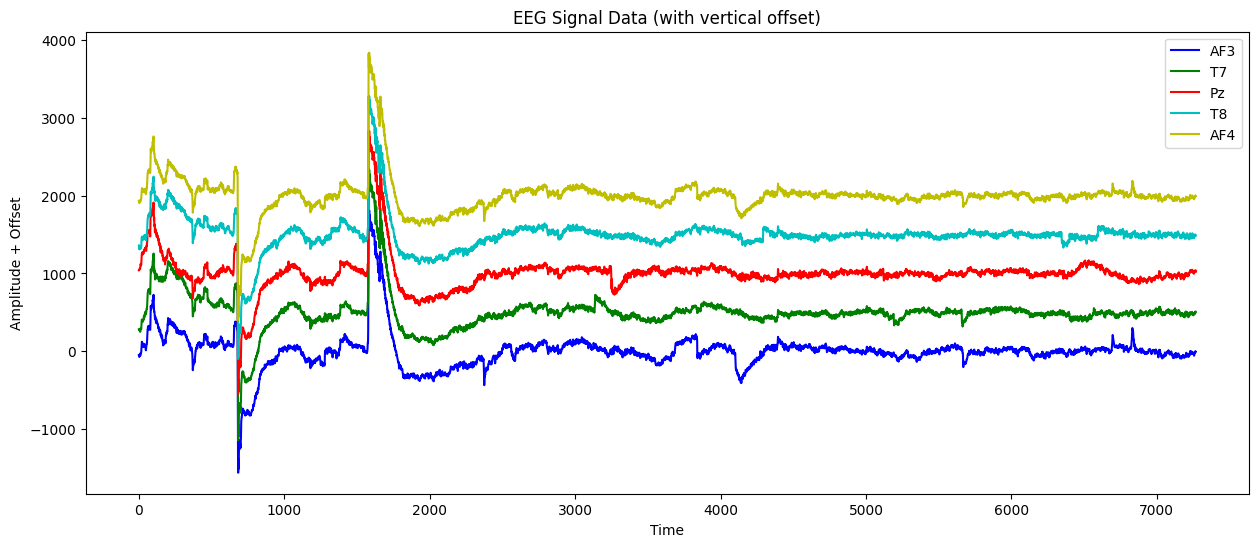

In [50]:
import scipy.io as sp
import json
import pprint as pp

_, mat_data, user_ids = get_genuine_csv_mat_files()
# print(mat_data)
def get_user_mat_data(user_id=None):
    if user_id is None:
        user_id = user_ids[0]  # Default to the first user if none specified
    user_files = [x for x in mat_data if user_id in x]
    user_files_sorted = pd.Series(user_files)
    user_files_sorted.sort_values(key=lambda x: x.str.split('_').str[3].astype(int), inplace=True)
    user_files_reset = user_files_sorted.reset_index(drop=True)
    # print(user_files_reset)
    return user_files_reset

# Fetch matlab data
mat_files_sorted = get_user_mat_data()
mat_content = sp.loadmat(mat_files_sorted[0])

# For debugging issues
to_print = mat_content['subject']

# converting ICA_EEG data into np structured array
eeg_columns = [i for i in mat_content['subject']['EEGHeader'][0][0][0].split(", ")]
eeg_data_list = [i.tolist() for i in mat_content['subject']['ICA_EEG'][0][0]]
print(eeg_data_list)
eeg_data = pd.DataFrame(eeg_data_list).T
eeg_data.columns = eeg_columns
# pp.pprint(eeg_data)
# Side note: Can be used for sign data as well, reduces dependency on CSV data

plt.figure(figsize=(15, 6))
offset = 500
colors = ['b', 'g', 'r', 'c', 'y']
for idx, col in enumerate(eeg_columns):
    plt.plot(eeg_data[col] + idx * offset, color=colors[idx % len(colors)], label=col)
plt.title('EEG Signal Data (with vertical offset)')
plt.xlabel('Time')
plt.ylabel('Amplitude + Offset')
plt.legend(loc='upper right')
plt.show()